In [1]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/var/folders/5q/ykn6qbsx111dmy75dk_f9z2w0000gn/T/ipykernel_4112/1408733200.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Load the dataset with low_memory=False to suppress DtypeWarning
df = pd.read_csv("../Data/All lending loan club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv", low_memory=False)

In [3]:
# Filter out loan status entries
df = df.loc[(df['loan_status'] == 'Charged Off') | (df['loan_status'] == 'Fully Paid')]

In [4]:
# Display basic information about the filtered dataset
print("Shape of the filtered dataset:", df.shape)
print("\nColumn names and data types:")
df.dtypes

Shape of the filtered dataset: (1345310, 151)

Column names and data types:


id                        object
member_id                float64
loan_amnt                float64
funded_amnt              float64
funded_amnt_inv          float64
                          ...   
settlement_status         object
settlement_date           object
settlement_amount        float64
settlement_percentage    float64
settlement_term          float64
Length: 151, dtype: object

In [5]:
# Display the first few rows of the filtered dataset
print("\nFirst few rows of the filtered dataset:")
df.head()


First few rows of the filtered dataset:


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
5,68426831,NaN,11950.0,11950.0,11950.0,36 months,13.44,405.18,C,C3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Summary statistics for numeric variables
numeric_vars = ['installment']
print("\nSummary statistics for numeric variables:")
df[numeric_vars].groupby(df['loan_status']).describe()


Summary statistics for numeric variables:


installment                                                 \
                  count        mean         std    min     25%     50%   
loan_status                                                              
Charged Off    268559.0  465.147994  262.774106  21.62  275.29  402.83   
Fully Paid    1076751.0  431.323226  260.759563   4.93  240.92  368.26   

                              
                75%      max  
loan_status                   
Charged Off  605.31  1717.63  
Fully Paid   573.06  1719.83

In [7]:
# Summary statistics for categorical variables
categorical_vars = ['verification_status', 'installment', 'emp_length', 'term', 'grade', 'sub_grade']
print("\nSummary statistics for categorical variables:")
for var in categorical_vars:
    df.groupby(['loan_status', var]).size().unstack()


Summary statistics for categorical variables:


In [8]:
# Check for missing values
print("\nMissing values:")
df.isnull().sum()


Missing values:


id                             0
member_id                1345310
loan_amnt                      0
funded_amnt                    0
funded_amnt_inv                0
                          ...   
settlement_status        1312034
settlement_date          1312034
settlement_amount        1312034
settlement_percentage    1312034
settlement_term          1312034
Length: 151, dtype: int64

## Exploratory Data Analysis (EDA)

`loan_amnt`

In [9]:
df['loan_amnt'].describe()

count    1.345310e+06
mean     1.441997e+04
std      8.717051e+03
min      5.000000e+02
25%      8.000000e+03
50%      1.200000e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64

/var/folders/5q/ykn6qbsx111dmy75dk_f9z2w0000gn/T/ipykernel_4112/918510729.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df,x="loan_status",y="loan_amnt",ax=ax[1],palette = {'Fully Paid': 'green', 'Charged Off': 'red'}).set(xlabel='Loan Status',


[Text(0.5, 0, 'Loan Status'), Text(0, 0.5, 'Amount in USD')]

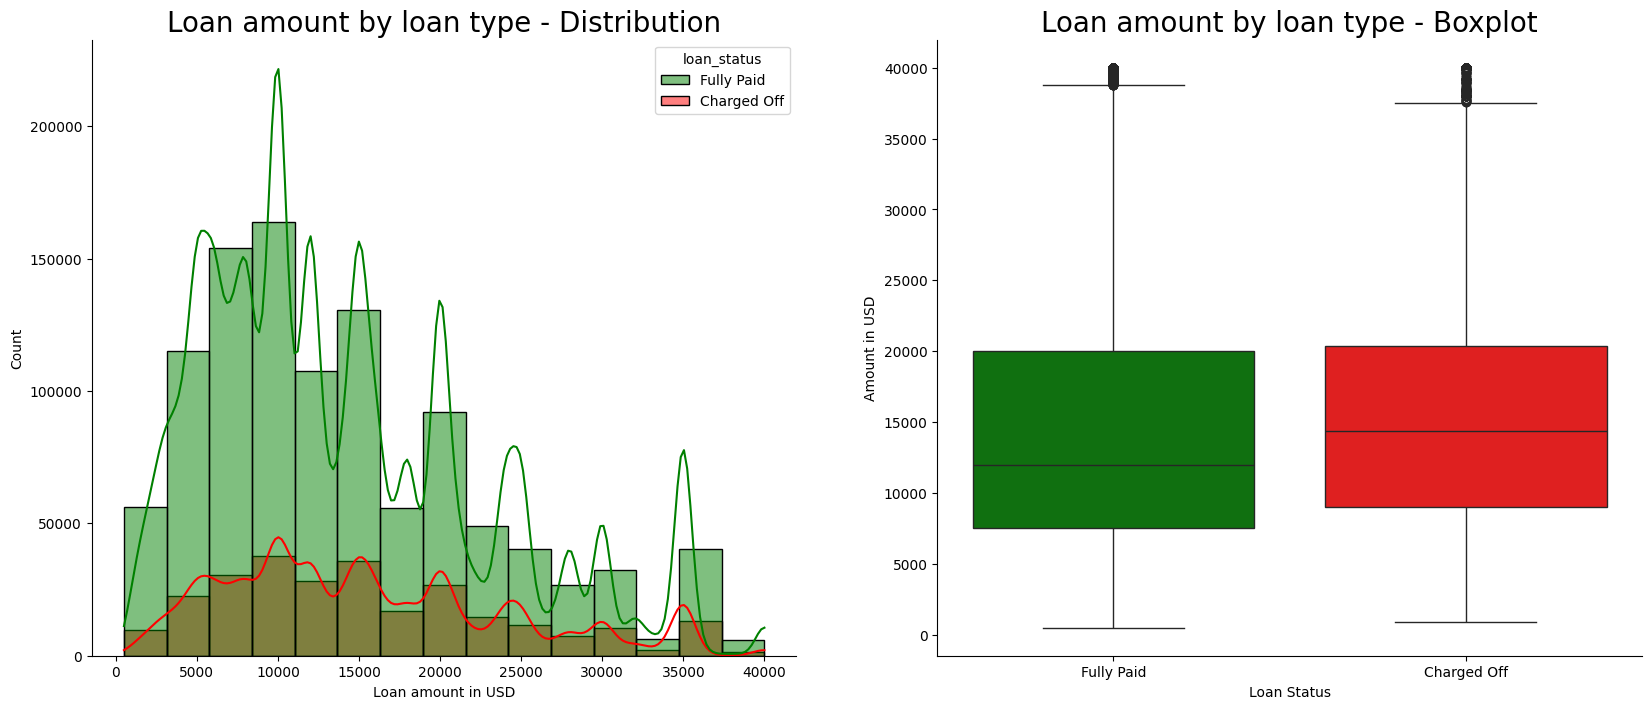

In [10]:
fig, ax =plt.subplots(1,2,figsize=(20,8))

sns.despine()

ax[0].tick_params(axis='x', labelrotation=0)
ax[0].set(xlabel='Loan amount in USD', ylabel='')
ax[0].set_title('Loan amount by loan type - Distribution', size=20)
ax[1].tick_params(axis='x', labelrotation=0)
ax[1].set_title('Loan amount by loan type - Boxplot', size=20)

sns.histplot(data=df,x="loan_amnt",hue="loan_status",bins=15,
             kde=True,ax=ax[0], palette = {'Fully Paid': 'green', 'Charged Off': 'red'})
sns.boxplot(data=df,x="loan_status",y="loan_amnt",ax=ax[1],palette = {'Fully Paid': 'green', 'Charged Off': 'red'}).set(xlabel='Loan Status',
                                                                                                                        ylabel='Amount in USD')

As observed in the histogram plot, `loan_amnt`'s distribution is right skewed. From looking at the boxplot, the feature descriptively looks pretty much normal with relatively low number of outliers.

`revol_bal`

In [11]:
df['revol_bal'].describe()

count    1.345310e+06
mean     1.624811e+04
std      2.232817e+04
min      0.000000e+00
25%      5.943000e+03
50%      1.113400e+04
75%      1.975575e+04
max      2.904836e+06
Name: revol_bal, dtype: float64

/var/folders/5q/ykn6qbsx111dmy75dk_f9z2w0000gn/T/ipykernel_4112/1554113752.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df,x="loan_status",y="revol_bal",ax=ax[1],palette = {'Fully Paid': 'green', 'Charged Off': 'red'}).set(xlabel='Loan status',


[Text(0.5, 0, 'Loan status'), Text(0, 0.5, 'Amount in USD')]

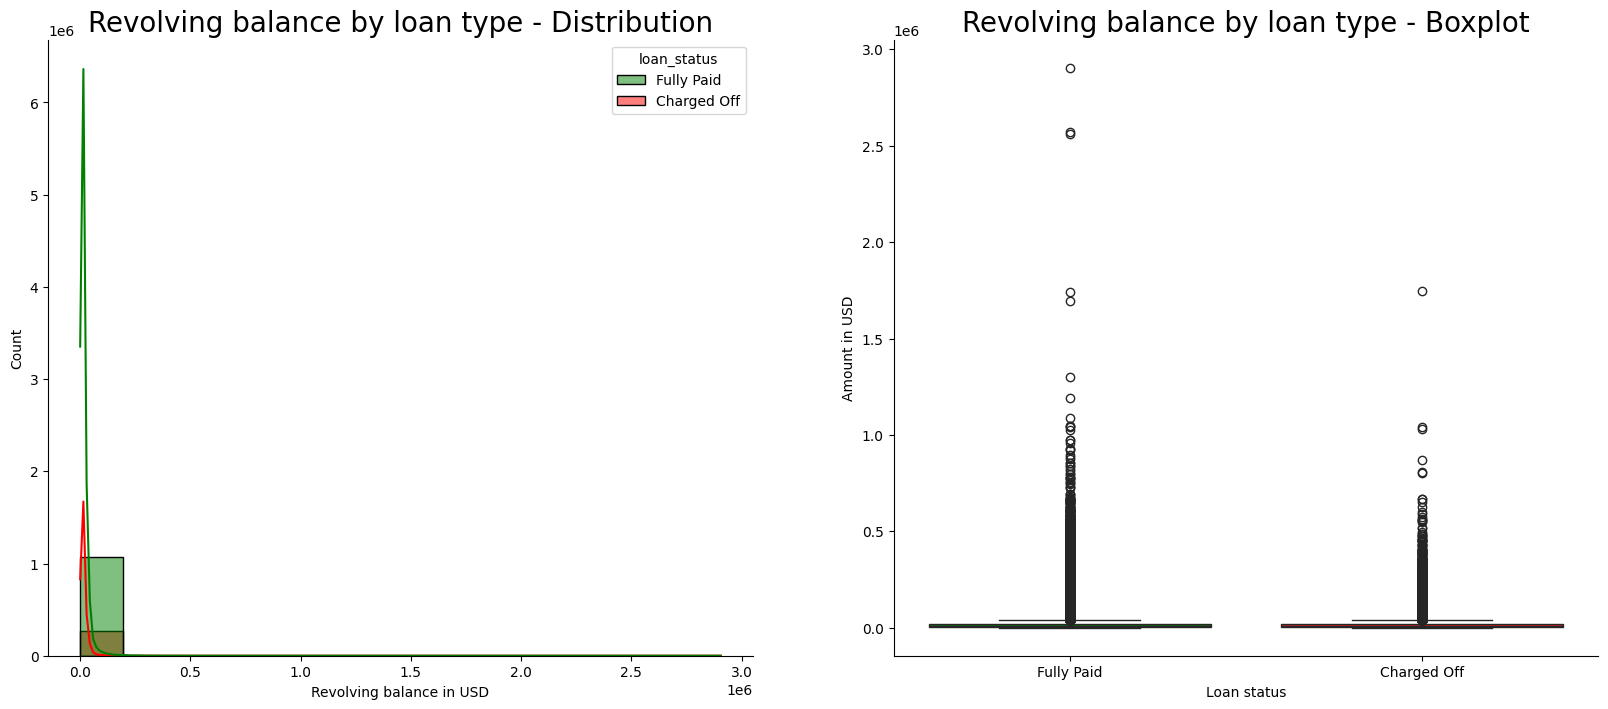

In [12]:
fig, ax =plt.subplots(1,2,figsize=(20,8))

sns.despine()

ax[0].tick_params(axis='x', labelrotation=0)
ax[0].set(xlabel='Revolving balance in USD', ylabel='')
ax[0].set_title('Revolving balance by loan type - Distribution', size=20)
ax[1].tick_params(axis='x', labelrotation=0)
ax[1].set_title('Revolving balance by loan type - Boxplot', size=20)

sns.histplot(data=df,x="revol_bal",hue="loan_status",bins=15,
             kde=True,ax=ax[0],palette = {'Fully Paid': 'green', 'Charged Off': 'red'})
sns.boxplot(data=df,x="loan_status",y="revol_bal",ax=ax[1],palette = {'Fully Paid': 'green', 'Charged Off': 'red'}).set(xlabel='Loan status',
                                                                                                                        ylabel='Amount in USD')

By looking at the boxplot, the feature seems to be right skewed. Also, it seems like there are a lot of outliers within the feature. 

`fico_range_high`

In [13]:
df['fico_range_high'].describe()

count    1.345310e+06
mean     7.001852e+02
std      3.185316e+01
min      6.290000e+02
25%      6.740000e+02
50%      6.940000e+02
75%      7.140000e+02
max      8.500000e+02
Name: fico_range_high, dtype: float64

/var/folders/5q/ykn6qbsx111dmy75dk_f9z2w0000gn/T/ipykernel_4112/4037852185.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df,x="loan_status",y="fico_range_high",ax=ax[1], palette = {'Fully Paid': 'green', 'Charged Off': 'red'}).set(xlabel='Loan status',


[Text(0.5, 0, 'Loan status'), Text(0, 0.5, 'FICO score high range')]

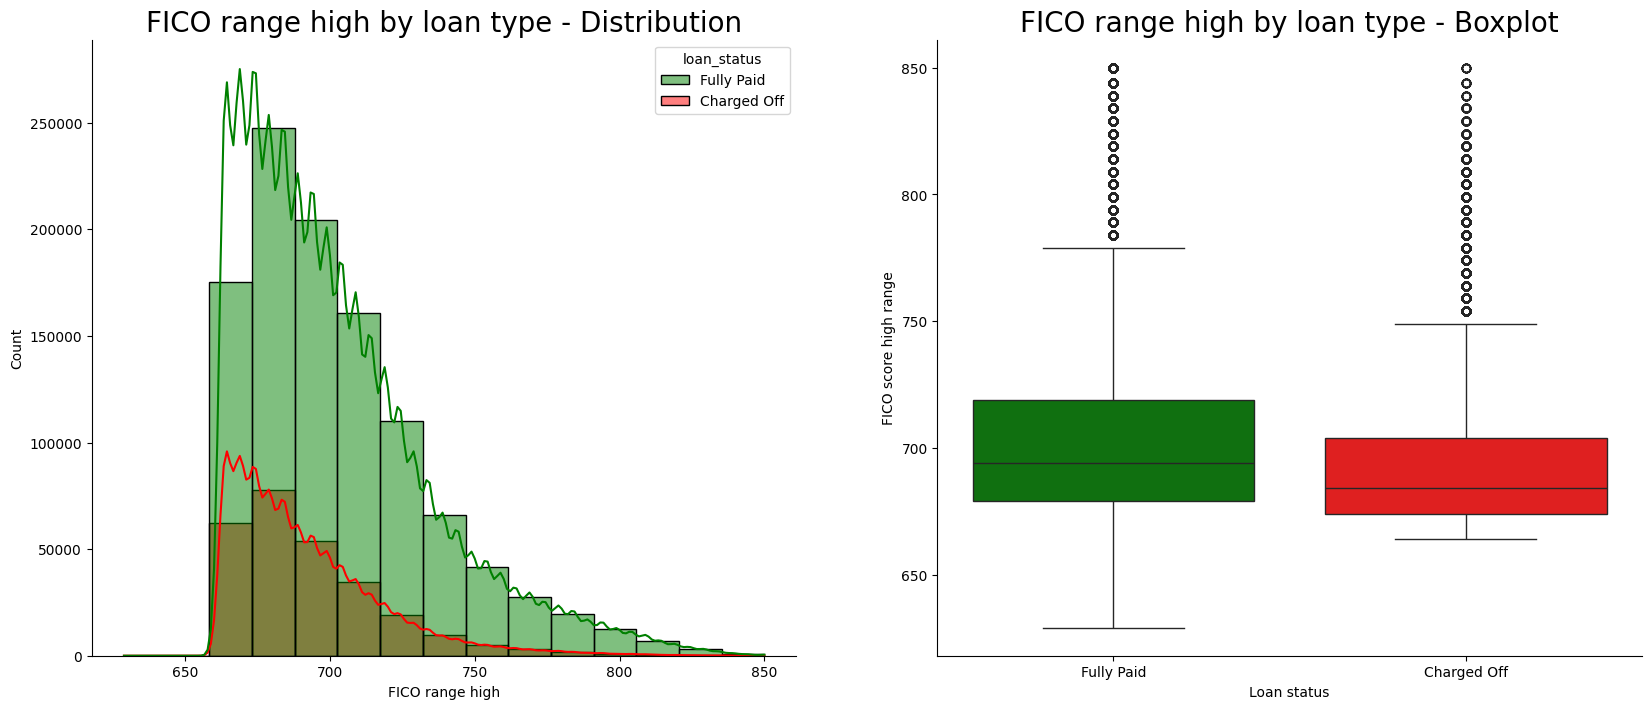

In [14]:
fig, ax =plt.subplots(1,2,figsize=(20,8))

sns.despine()

ax[0].tick_params(axis='x', labelrotation=0)
ax[0].set(xlabel='FICO range high', ylabel='')
ax[0].set_title('FICO range high by loan type - Distribution', size=20)
ax[1].tick_params(axis='x', labelrotation=0)
ax[1].set_title('FICO range high by loan type - Boxplot', size=20)

sns.histplot(data=df,x="fico_range_high",hue="loan_status",bins=15,
             kde=True,ax=ax[0], palette = {'Fully Paid': 'green', 'Charged Off': 'red'})
sns.boxplot(data=df,x="loan_status",y="fico_range_high",ax=ax[1], palette = {'Fully Paid': 'green', 'Charged Off': 'red'}).set(xlabel='Loan status',
                                                                                                                               ylabel='FICO score high range')

`fico_range_low`

In [15]:
df['fico_range_low'].describe()

count    1.345310e+06
mean     6.961850e+02
std      3.185251e+01
min      6.250000e+02
25%      6.700000e+02
50%      6.900000e+02
75%      7.100000e+02
max      8.450000e+02
Name: fico_range_low, dtype: float64

/var/folders/5q/ykn6qbsx111dmy75dk_f9z2w0000gn/T/ipykernel_4112/3124862747.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df,x="loan_status",y="fico_range_low",ax=ax[1], palette = {'Fully Paid': 'green', 'Charged Off': 'red'}).set(xlabel='Loan status',


[Text(0.5, 0, 'Loan status'), Text(0, 0.5, 'FICO score low range')]

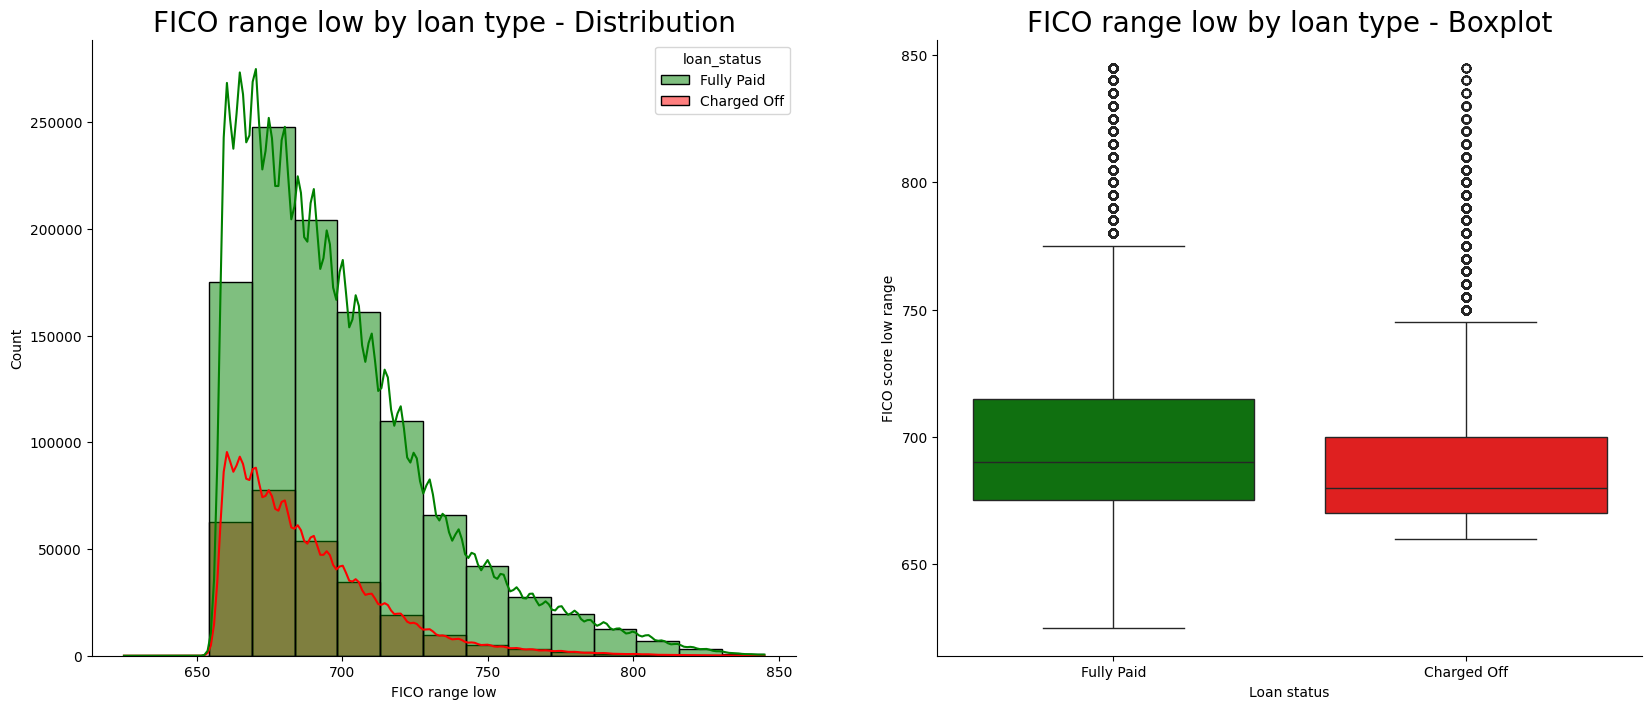

In [16]:
fig, ax =plt.subplots(1,2,figsize=(20,8))

sns.despine()

ax[0].tick_params(axis='x', labelrotation=0)
ax[0].set(xlabel='FICO range low', ylabel='')
ax[0].set_title('FICO range low by loan type - Distribution', size=20)
ax[1].tick_params(axis='x', labelrotation=0)
ax[1].set_title('FICO range low by loan type - Boxplot', size=20)

sns.histplot(data=df,x="fico_range_low",hue="loan_status",bins=15,
             kde=True,ax=ax[0], palette = {'Fully Paid': 'green', 'Charged Off': 'red'})
sns.boxplot(data=df,x="loan_status",y="fico_range_low",ax=ax[1], palette = {'Fully Paid': 'green', 'Charged Off': 'red'}).set(xlabel='Loan status',
                                                                                                                              ylabel='FICO score low range')

`fico_range_high` and `fico_range_low` has pretty similar distribution. This is expected since FICO scores typically follow a range. Consider taking the average of these two features since it won't change their distribution all that much.

`purpose`

First, let's investigate the number of unique entries contained within the feature.

In [17]:
df['purpose'].nunique()

14

In [18]:
df['purpose'].unique().tolist()

['debt_consolidation',
 'small_business',
 'home_improvement',
 'major_purchase',
 'credit_card',
 'other',
 'house',
 'vacation',
 'car',
 'medical',
 'moving',
 'renewable_energy',
 'wedding',
 'educational']

Investigate the number of each loan applications on each loan `purpose` with respect to `loan_status`.

<Axes: xlabel='purpose', ylabel='count'>

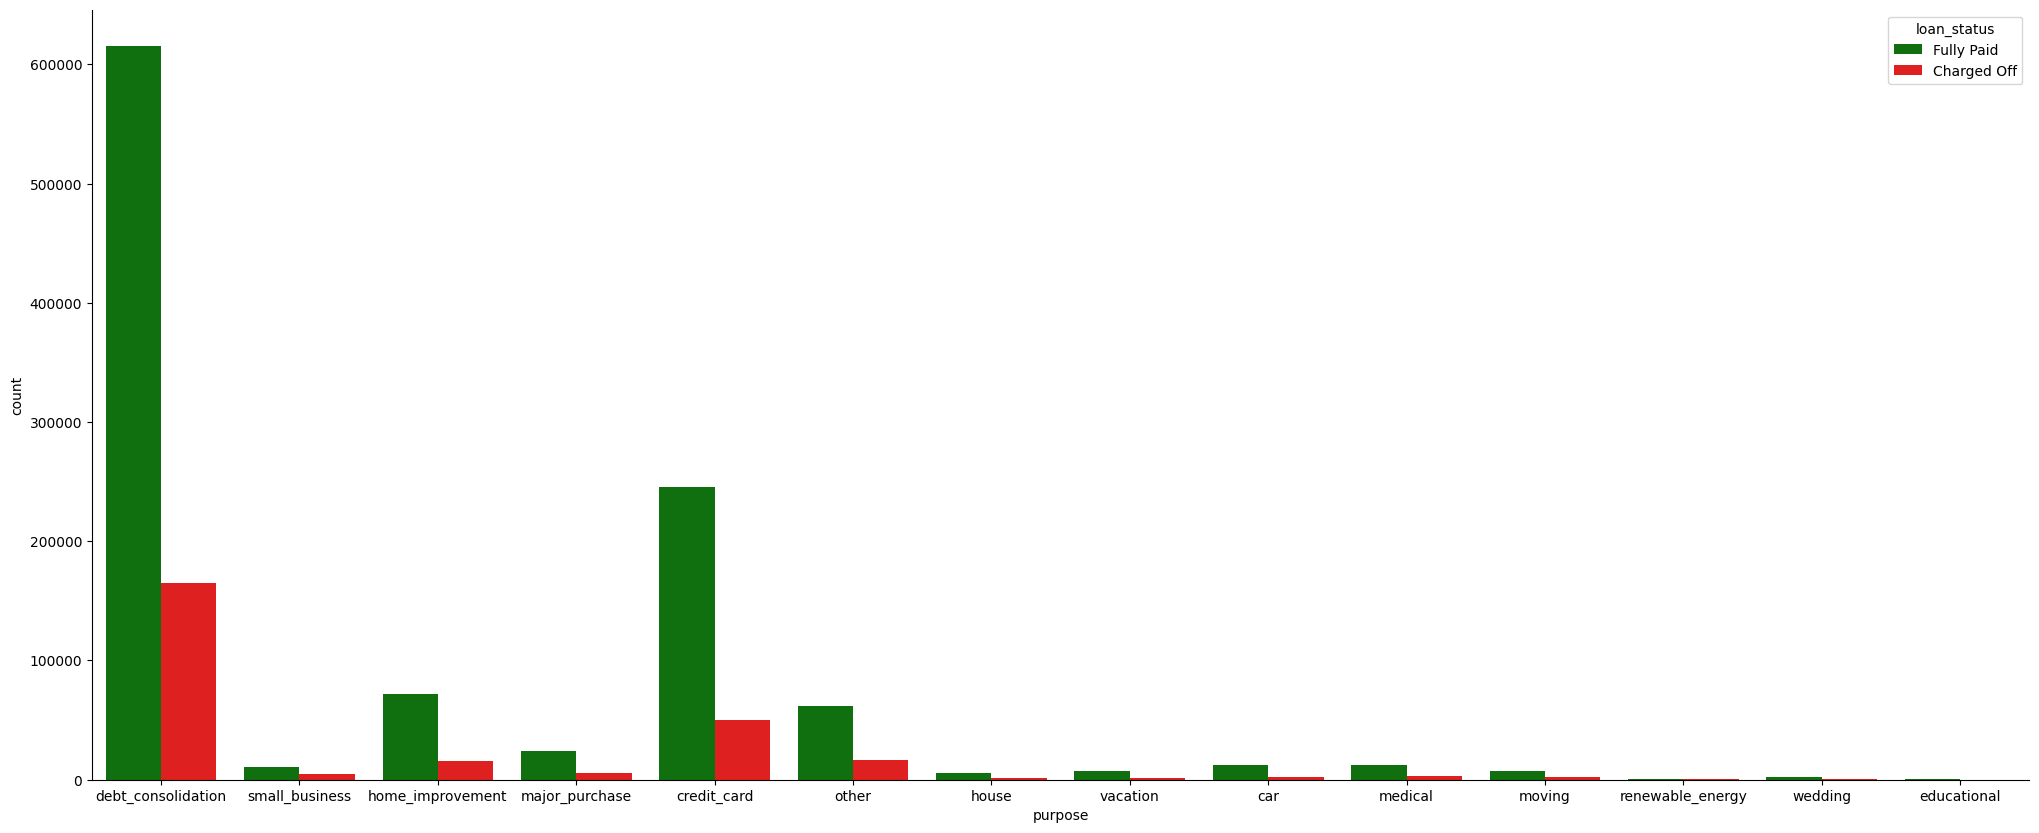

In [19]:
fig, ax = plt.subplots(figsize=(25, 10))
sns.despine()
sns.countplot(data=df, x='purpose', hue='loan_status', palette = {'Fully Paid': 'green', 'Charged Off': 'red'})

Based on the graph, `debt_consolidation`, `home_improvement`, and `credit_card` have the highest number of charged off loans. However, it is quite hard to conclude the percentage of charge off loans for each category. Therefore, we create a table calculating the percentage of charged off loans for each purpose.

In [20]:
df_co = df[df['loan_status'] == 'Charged Off'].groupby('purpose').count()[['loan_status']]

df_total = df.groupby('purpose').count()[['loan_status']]

percent_co = df_co / df_total * 100

percent_co.rename(columns={'loan_status': 'Percentage Charged Off Loans'}).reset_index()

,purpose,Percentage Charged Off Loans
0,car,14.679465
1,credit_card,16.927042
2,debt_consolidation,21.146938
3,educational,17.177914
4,home_improvement,17.715762
5,house,21.880601
6,major_purchase,18.599830
7,medical,21.775749
8,moving,23.354430
9,other,21.040128


`small_business`, `renewable_energy`, and `moving` have the highest percentage of charged off loans.

`dti`

In [21]:
df['dti'].describe()

count    1.344936e+06
mean     1.828267e+01
std      1.116045e+01
min     -1.000000e+00
25%      1.179000e+01
50%      1.761000e+01
75%      2.406000e+01
max      9.990000e+02
Name: dti, dtype: float64

`dti` should not be negative as a negative DTI ratio would imply either negative debt (which doesn't make sense in this context, as you can't owe negative money) or negative income (which would indicate that you are paying to work, rather than earning from work). Both scenarios are not feasible in standard financial practice. Let's inspect how many data points has a negative value.

In [22]:
df[df['dti'] < 0]['dti'].value_counts()

dti
-1.0    2
Name: count, dtype: int64

There are 2 data points within this feature having negative value. Further processing should be performed on this two instances. Recommend dropping these points as they don't represent the majority of the data.

/var/folders/5q/ykn6qbsx111dmy75dk_f9z2w0000gn/T/ipykernel_4112/183534431.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df,x="loan_status",y="dti",ax=ax[1], palette = {'Fully Paid': 'green', 'Charged Off': 'red'}).set(xlabel='Loan status',


[Text(0.5, 0, 'Loan status'), Text(0, 0.5, 'dti')]

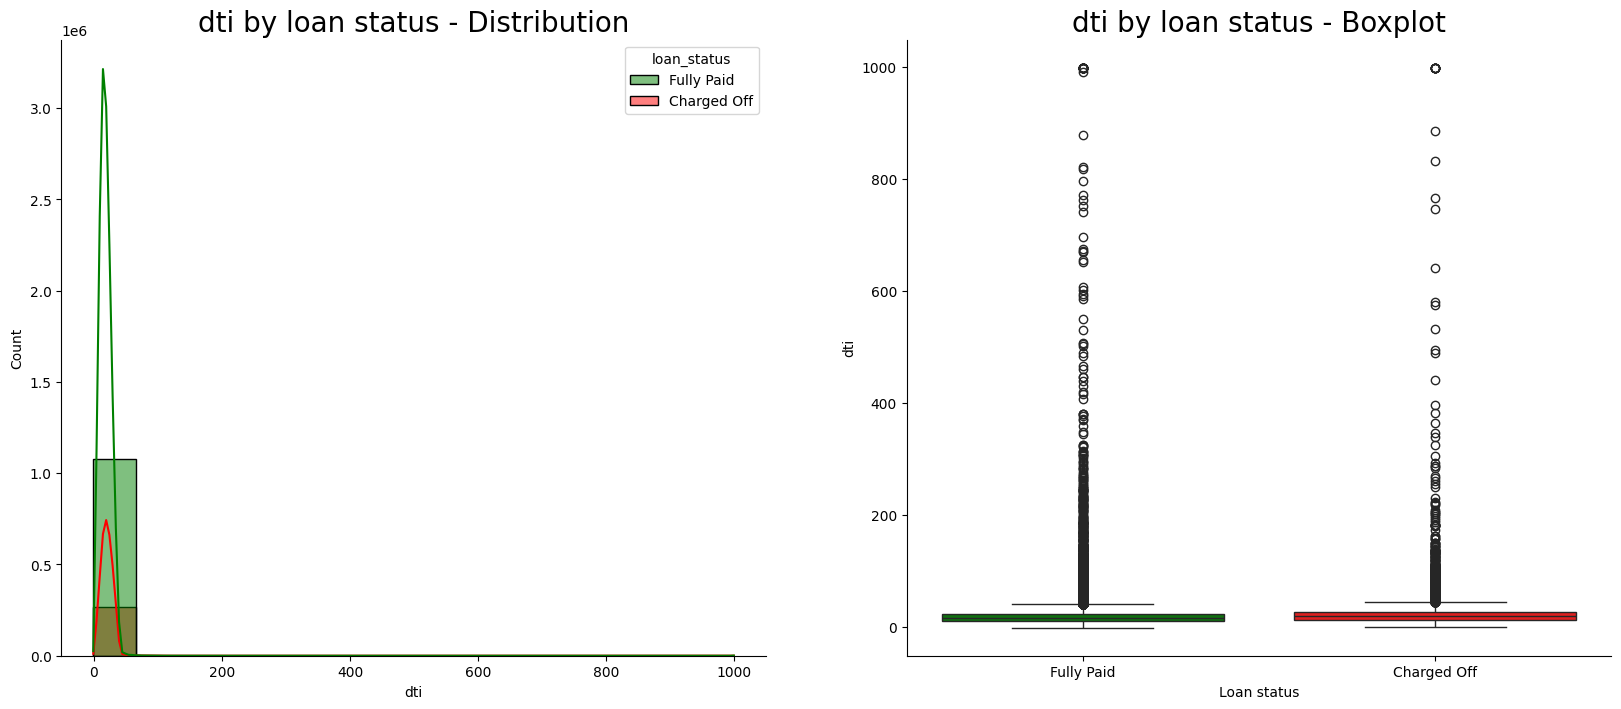

In [23]:
fig, ax =plt.subplots(1,2,figsize=(20,8))

sns.despine()

ax[0].tick_params(axis='x', labelrotation=0)
ax[0].set(xlabel='dti', ylabel='')
ax[0].set_title('dti by loan status - Distribution', size=20)
ax[1].tick_params(axis='x', labelrotation=0)
ax[1].set_title('dti by loan status - Boxplot', size=20)

sns.histplot(data=df,x="dti",hue="loan_status",bins=15,
             kde=True,ax=ax[0], palette = {'Fully Paid': 'green', 'Charged Off': 'red'})
sns.boxplot(data=df,x="loan_status",y="dti",ax=ax[1], palette = {'Fully Paid': 'green', 'Charged Off': 'red'}).set(xlabel='Loan status',
                                                                                                                   ylabel='dti')

By looking at the boxplot, this feature is right skewed with numerous outliers.

`issue_d` 

Convert `issue_d` column to DateTime type

In [24]:
df['issue_d'] = pd.to_datetime(df['issue_d'])

/var/folders/5q/ykn6qbsx111dmy75dk_f9z2w0000gn/T/ipykernel_4112/3004380484.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['issue_d'] = pd.to_datetime(df['issue_d'])


Create a year column

In [25]:
df['year'] = df['issue_d'].dt.year

<Axes: xlabel='year', ylabel='count'>

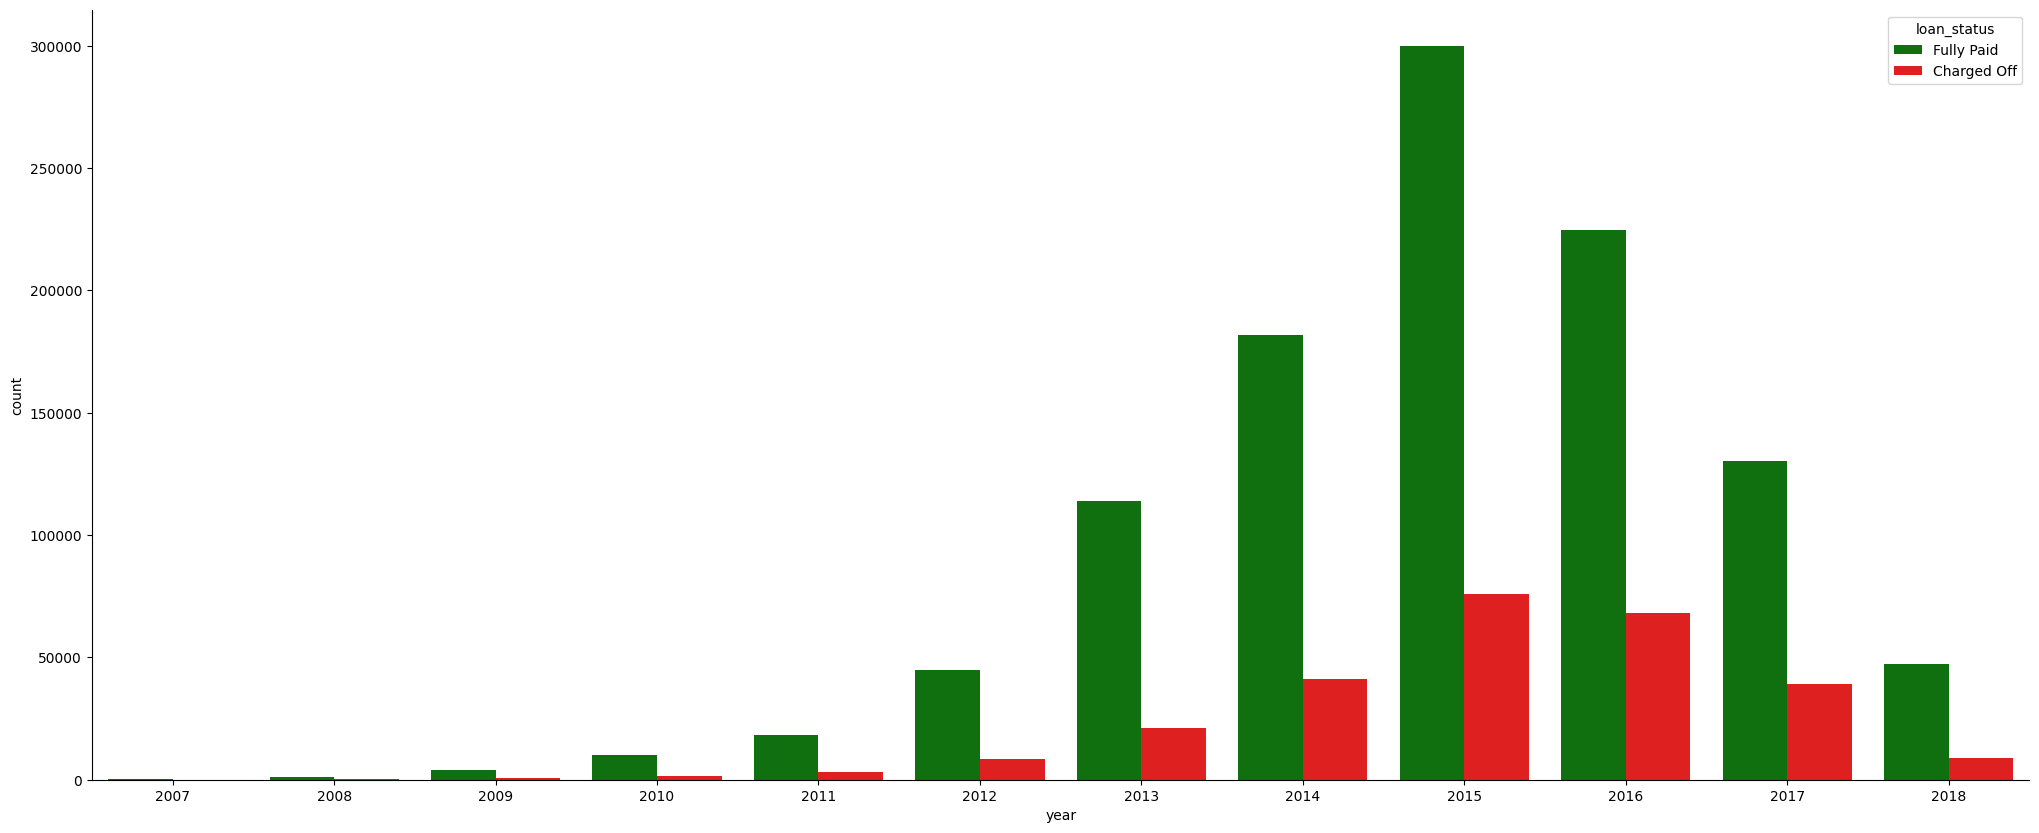

In [26]:
fig, ax = plt.subplots(figsize=(25, 10))
sns.despine()
sns.countplot(data=df, x='year', hue='loan_status', palette = {'Fully Paid': 'green', 'Charged Off': 'red'})

Based on the graph, the period from 2013 to 2017 has the highest number of loan applications. However, we can't see the percentage of charged off loans within each year. Let's create a table to calculate this.

In [27]:
df_co = df[df['loan_status'] == 'Charged Off'].groupby('year').count()[['loan_status']]

df_total = df.groupby('year').count()[['loan_status']]

percent_co = df_co / df_total * 100

percent_co.rename(columns={'loan_status': 'Percentage Charged Off Loans'}).reset_index()

,year,Percentage Charged Off Loans
0,2007,17.928287
1,2008,15.813060
2,2009,12.595420
3,2010,12.890083
4,2011,15.178859
5,2012,16.197275
6,2013,15.595976
7,2014,18.449409
8,2015,20.184798
9,2016,23.283236


Based on the table, `2015`, `2016`, and `2017` are the years with the highest percentage of charged off loans.

`verification_status`

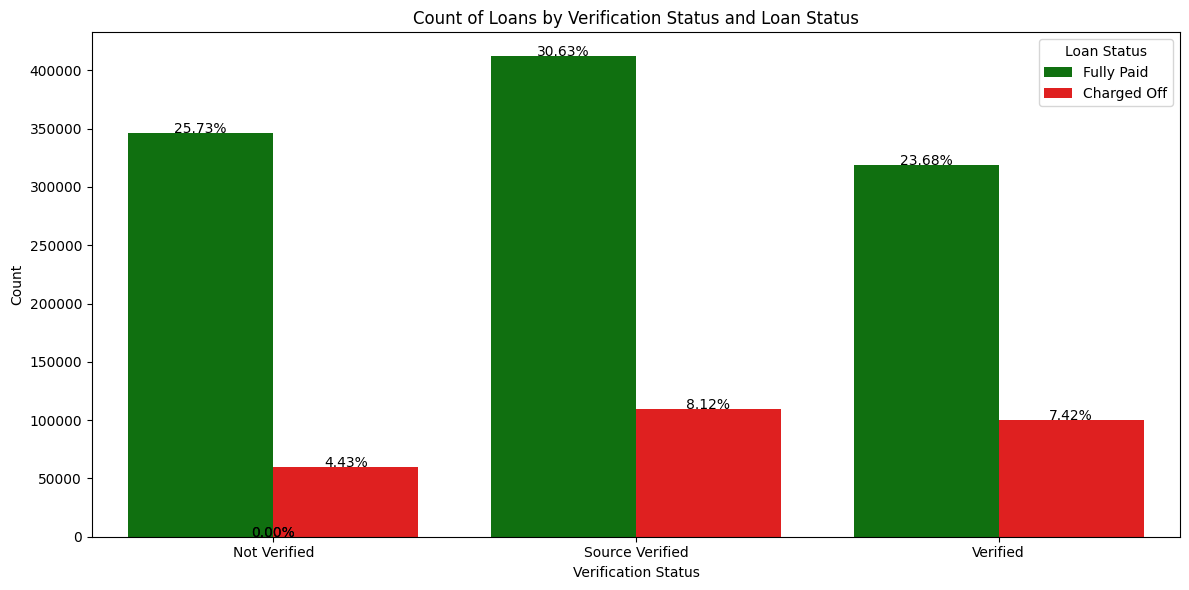

In [28]:
# 1. Countplot of verification status by loan status
plt.figure(figsize=(12, 6))  
ax = sns.countplot(x='verification_status', hue='loan_status', data=df,
              palette={'Charged Off': 'red', 'Fully Paid': 'green'})

# Calculate percentage for each bar
total = float(len(df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3,
            '{:.2f}%'.format((height / total) * 100),
            ha="center")

plt.title('Count of Loans by Verification Status and Loan Status')
plt.xlabel('Verification Status')
plt.ylabel('Count')
plt.legend(title='Loan Status', loc='upper right')
plt.tight_layout() 
plt.show()

All green bars (fully paid) are much taller than the red bars (charged off). The majority of loans are fully paid, indicating a higher success rate compared to charged off loans.

`installment`

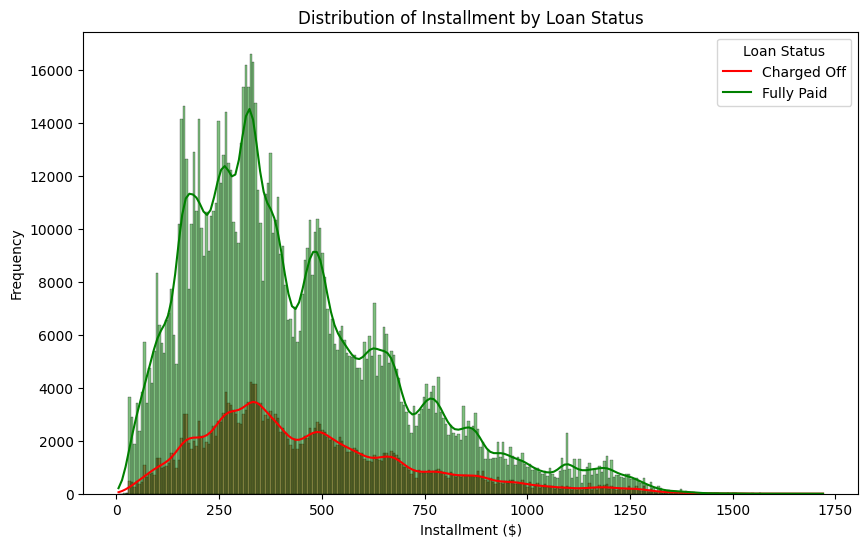

In [29]:
# 2. Distribution of installment by loan status
plt.figure(figsize=(10, 6))
sns.histplot(df, x='installment', hue='loan_status', kde=True, palette={'Charged Off': 'red', 'Fully Paid': 'green'}, legend=True)
plt.title('Distribution of Installment by Loan Status')
plt.xlabel('Installment ($)')
plt.ylabel('Frequency')
plt.legend(title='Loan Status', labels=['Charged Off', 'Fully Paid'])
plt.show()

The distribution of installment amounts is right-skewed for both fully paid and charged off loans. Green (fully paid) distribution has a higher peak compared to the red (charged off) distribution.

`emp_length`

In [30]:
df['emp_length']

0          10+ years
1          10+ years
2          10+ years
4            3 years
5            4 years
             ...    
2260688      5 years
2260690      9 years
2260691      3 years
2260692    10+ years
2260697      6 years
Name: emp_length, Length: 1345310, dtype: object

In [31]:
# 3. Countplot of employment length by loan status
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='emp_length_group', hue='loan_status', data=df,
                   palette={'Charged Off': 'red', 'Fully Paid': 'green'})

# Calculate percentage for each bar
total = float(len(df))
for p in ax.patches:
    height = p.get_height()
    if np.isnan(height):  # Check if height is NaN
        height = 0
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3,
            '{:.2f}%'.format((height / total) * 100),
            ha="center")

plt.title('Count of Loans by Employment Length Group and Loan Status')
plt.xlabel('Employment Length')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Loan Status')
plt.show()

ValueError: Could not interpret value `emp_length_group` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

Employment length between 10 to 12 years have the highest count of loans, and there's none more than 12 years.

`term`

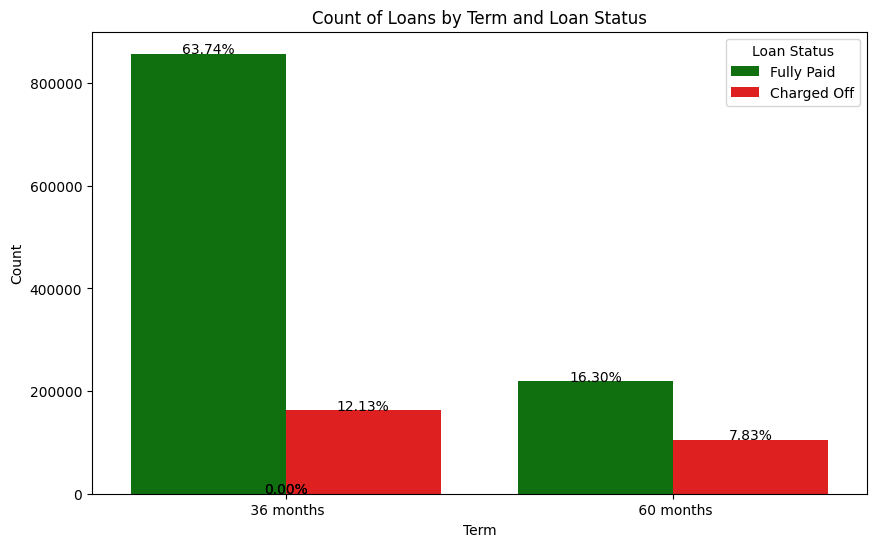

In [34]:
# 4. Countplot of loan term by loan status
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='term', hue='loan_status', data=df,
                   palette={'Charged Off': 'red', 'Fully Paid': 'green'})

# Calculate percentage for each bar
total = float(len(df))
for p in ax.patches:
    height = p.get_height()
    if np.isnan(height):  # Check if height is NaN
        height = 0
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3,
            '{:.2f}%'.format((height / total) * 100),
            ha="center")

plt.title('Count of Loans by Term and Loan Status')
plt.xlabel('Term')
plt.ylabel('Count')
plt.legend(title='Loan Status', loc='upper right')
plt.show()

Loans with 36-months term are significantly most common among fully paid loans, while charged off loans show similar frequencies for both 36 and 60-month terms with less than 5% difference.

`grade`

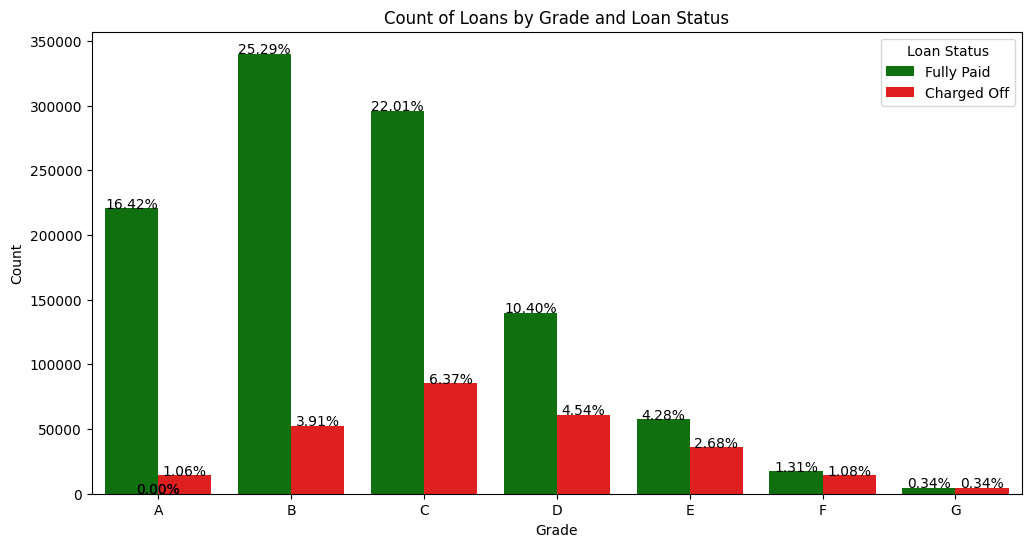

In [35]:
# 5. Countplot of loan grade by loan status
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='grade', hue='loan_status', data=df,
                   palette={'Charged Off': 'red', 'Fully Paid': 'green'},
                   order=sorted(df['grade'].unique()))

# Calculate percentage for each bar
total = float(len(df))
for p in ax.patches:
    height = p.get_height()
    if np.isnan(height):  # Check if height is NaN
        height = 0
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3,
            '{:.2f}%'.format((height / total) * 100),
            ha="center")

plt.title('Count of Loans by Grade and Loan Status')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.legend(title='Loan Status', loc='upper right')
plt.show()

Fully paid loans display Grade B being the most common. Charged off loans, on the other hand, exhibit a more even distribution across grade categories, with Grade C being the most frequent. Both fully paid and charged off loan counts are the same for Grade G.

`sub_grade`

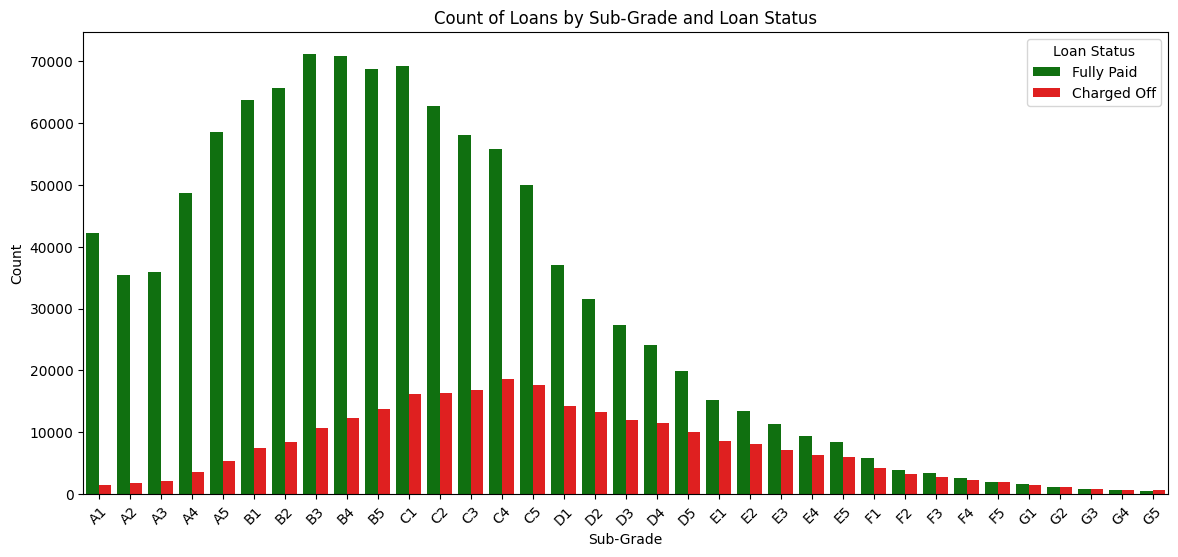

In [36]:
# 6. Countplot of loan sub-grade by loan status
plt.figure(figsize=(14, 6))
sns.countplot(x='sub_grade', hue='loan_status', data=df,
              palette={'Charged Off': 'red', 'Fully Paid': 'green'},
              order=sorted(df['sub_grade'].unique()))
plt.title('Count of Loans by Sub-Grade and Loan Status')
plt.xlabel('Sub-Grade')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Loan Status', loc='upper right')
plt.show()

The distribution of sub-grades provides additional information following the trend displayed for grades. Here, sub-grade B3 is the highest for fully paid, and sub-grade C4 for charged off loans.

`int_rate`

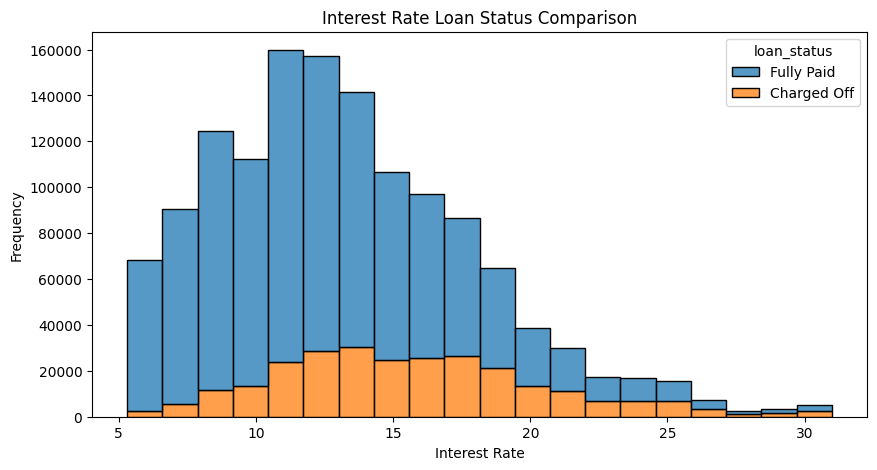

In [37]:
plt.figure(figsize=(10, 5))

sns.histplot(df, x="int_rate", bins=20, hue="loan_status", multiple="stack")
plt.title("Interest Rate Loan Status Comparison")
plt.xlabel("Interest Rate")
plt.ylabel("Frequency")
plt.show()

Based on the graph above, the higher the interest rate, the higher the probability of being charged off. The trend appears to be very strong and we may conclude that interest rate is a significant feature in predicting borrower's default risk.

`home_ownership`

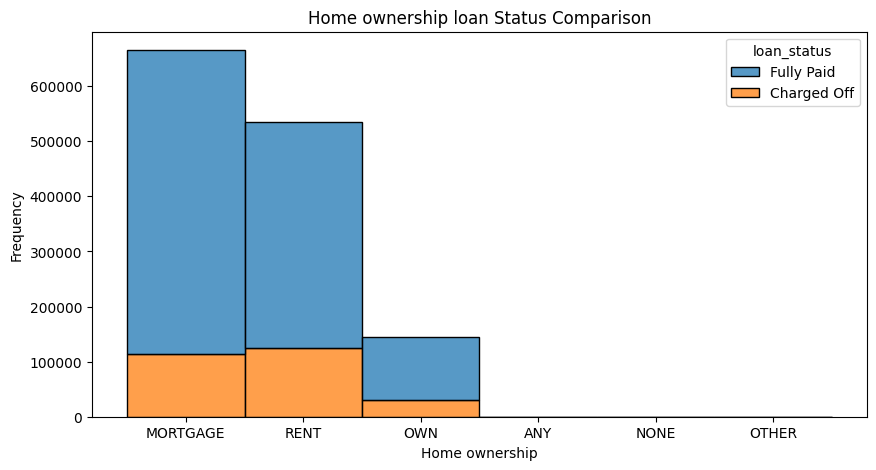

In [38]:
plt.figure(figsize=(10, 5))

sns.histplot(df, x="home_ownership", bins=20, hue="loan_status", multiple="stack")
plt.title("Home ownership loan Status Comparison")
plt.xlabel("Home ownership")
plt.ylabel("Frequency")
plt.show()

Borrowers who have a mortgage are more likely to be charged off as compared to borrowers who rent and own a home/house.
One of the possible reasons for the higher charge off probability for mortgage holders might be related to the fact that mortgages are highly related to the interest rate. The heatmap below further investigates the relationship between interest rate, home ownership and loan status. 

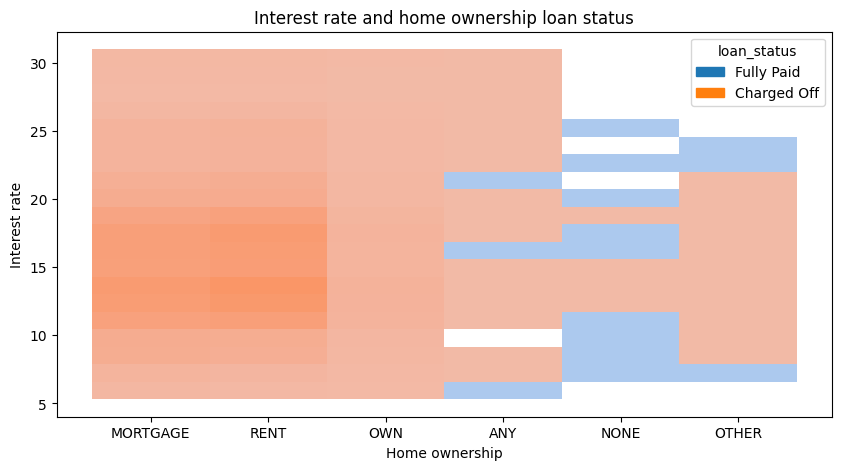

In [39]:
plt.figure(figsize=(10, 5))

sns.histplot(df, x="home_ownership", y="int_rate", bins=20, hue="loan_status", multiple="stack")
plt.title("Interest rate and home ownership loan status")
plt.xlabel("Home ownership")
plt.ylabel("Interest rate")
plt.show()

When interest rate is high, borrowers who rent are more likely to be charged off as compared to borrowers with mortgage or own a home. 

There is not significant relationship between interest rate and the probability of mortgage holders defaulting. The higher probability of mortgage holders being charged off is likely to be attributed to other factors. 

`zip_code`

`annual_inc`

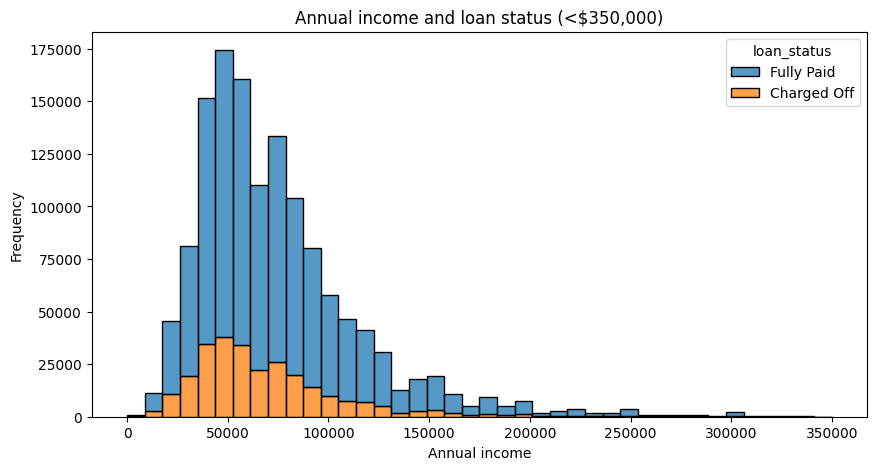

In [40]:
plt.figure(figsize=(10, 5))

sns.histplot(df[df['annual_inc']<350000], x="annual_inc", bins=40, hue="loan_status", multiple="stack")
plt.title("Annual income and loan status (<$350,000)")
plt.xlabel("Annual income")
plt.ylabel("Frequency")

plt.show()

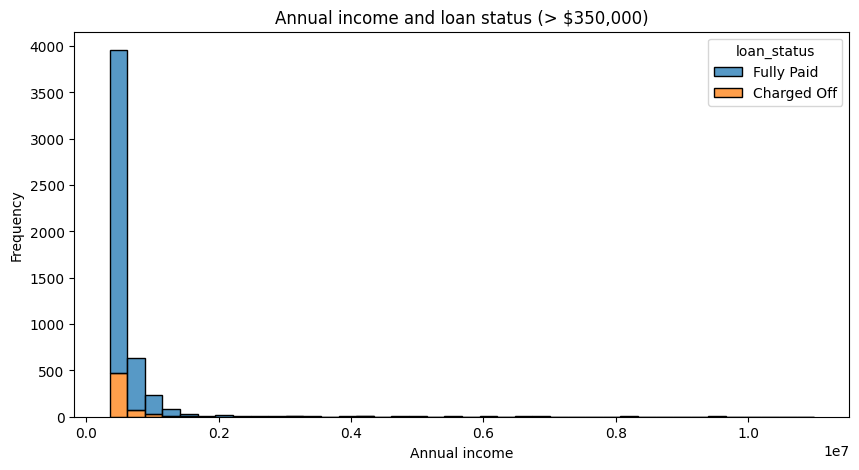

In [41]:
plt.figure(figsize=(10, 5))

sns.histplot(df[df['annual_inc']>350000], x="annual_inc", bins=40, hue="loan_status", multiple="stack")
plt.title("Annual income and loan status (> $350,000)")
plt.xlabel("Annual income")
plt.ylabel("Frequency")

plt.show()

Due to extreme outliers, the annual income is split into two categories, i.e. <350,000 and >350,000. For better trend visualization, the grouping in this scenario is set to bins=50. This grouping may/may not affect the trend.

Majority of the borrowers' annual income falls in the <350,000 category, with minority borrowers having more than >350,000 annual income. The probability of default decreases as the annual income increases. Borrowers with annual income of approximately 75,000 has the least chance of being charged off. 

In 2015, the average median income in USA was 56,516.
Taking into account the date of the data, it is accurate that majority of the borrowers' annual income falls between 50,000 to 100,000. 

There is currently a lack of statistical reasoning to explain why borrowers with 75,000 annual income have the least risk of being charged off, therefore it might be worthwhile to look further into this. 

The probability of default decreases as the annual income increases. The optimal point lies at approximately $75,000. 


`open_acc`

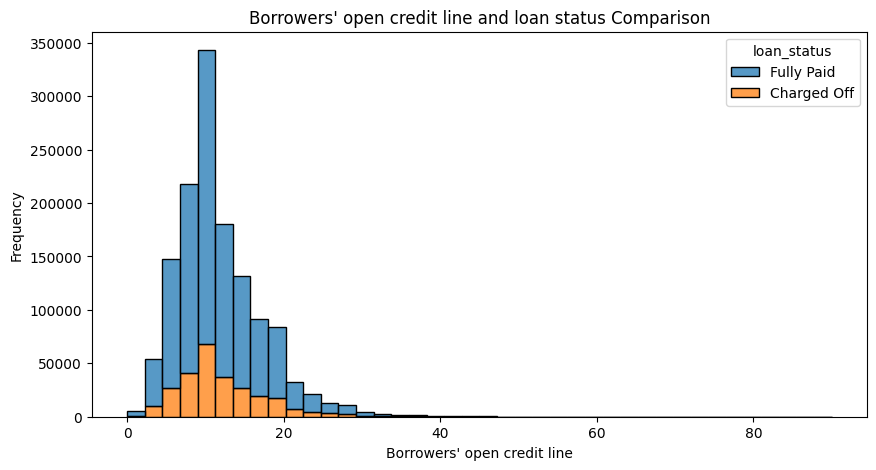

In [42]:
plt.figure(figsize=(10, 5))

sns.histplot(df.sort_values("grade"), x="open_acc", bins=40, hue="loan_status", multiple="stack")
plt.title("Borrowers' open credit line and loan status Comparison")
plt.xlabel("Borrowers' open credit line")
plt.ylabel("Frequency")
plt.show()

#Open_acc: The number of open credit lines in the borrower's credit file.

The probability of being charged off decreases as the borrowers' open credit line decreases. No major discrepancies in this occurence. 

`pub_rec`

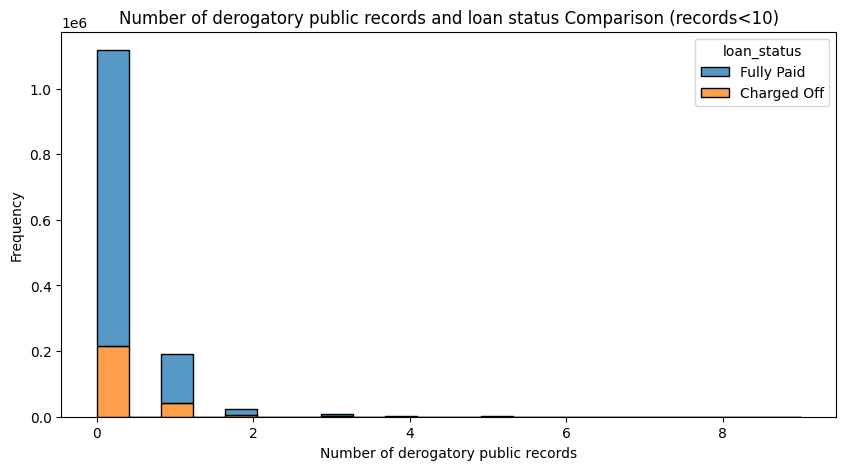

In [43]:
plt.figure(figsize=(10, 5))

sns.histplot(df[df['pub_rec']<10], x="pub_rec", hue="loan_status", multiple="stack")
plt.title("Number of derogatory public records and loan status Comparison (records<10)")
plt.xlabel("Number of derogatory public records")
plt.ylabel("Frequency")
plt.show()

#pub_rec: Number of derogatory public records

The data set is being split into <10 and >10 for better anaylsis.

Majority of the number of derogatory public records fall between 0 to 2. 
Most borrowers do not have any derogatory public records.

When the records < 10, the relationship between number of derogatory public records and loan status is weak.
See the graph below for when records > 10. 

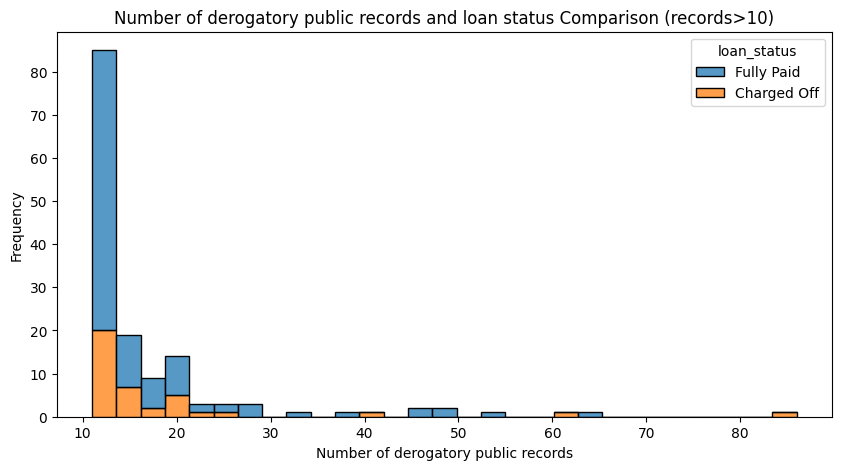

In [44]:
plt.figure(figsize=(10, 5))

sns.histplot(df[df['pub_rec']>10], x="pub_rec", hue="loan_status", multiple="stack")
plt.title("Number of derogatory public records and loan status Comparison (records>10)")
plt.xlabel("Number of derogatory public records")
plt.ylabel("Frequency")
plt.show()

There is a small number of people who holds more than >10 derogatory public records. 
At >10, the probability of being charged off increases when the number of records increase (approximately average of 30%). 

When the records > 10, the probability of being charged off increases when the number of records increase.

`total_acc`

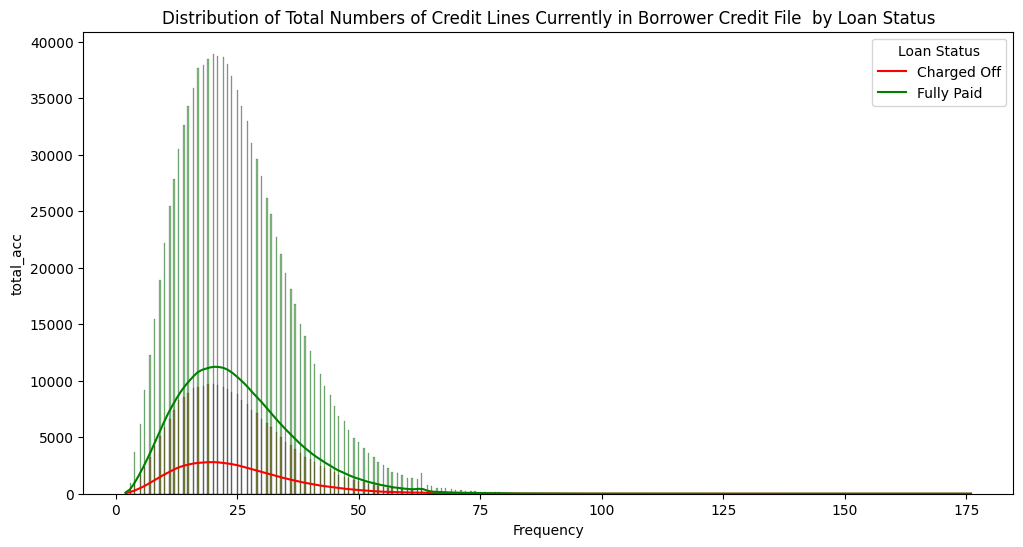

In [45]:
#Distribution of total numbers of credit lines currently in borrower's credit file by loan status
plt.figure(figsize=(12, 6))
sns.histplot(df, x='total_acc', hue='loan_status', kde=True, palette={'Charged Off': 'red', 'Fully Paid': 'green'}, legend=True)
plt.title('Distribution of Total Numbers of Credit Lines Currently in Borrower Credit File  by Loan Status')
plt.xlabel('Frequency')
plt.ylabel('total_acc')
plt.legend(title='Loan Status', labels=['Charged Off', 'Fully Paid'])
plt.show()

The distribution of fully paid loans is higher across all frequencies compared to charged-off loans, indicating that there are more fully paid accounts than charged-off accounts in the dataset.
The frequency of both loan statuses decreases as the number of credit lines increases, showing a right-skewed distribution.

`earliest_cr_line`

<function matplotlib.pyplot.show(close=None, block=None)>

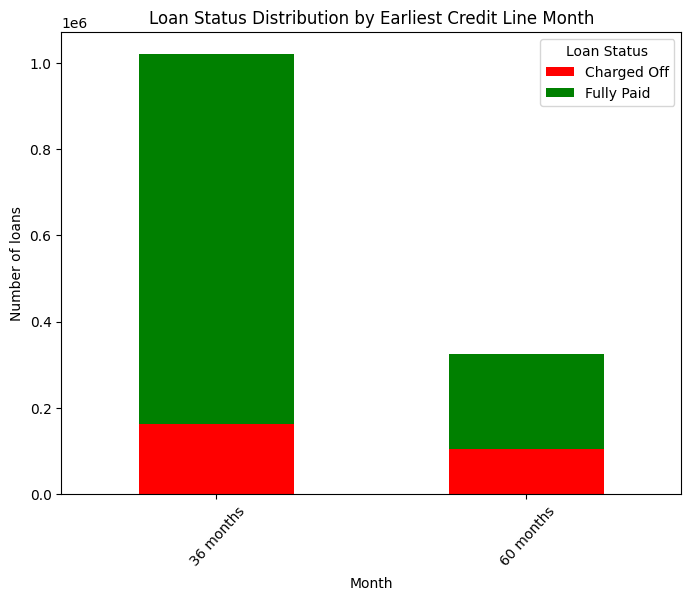

In [46]:
pivot_table = df.pivot_table(index='term', columns='loan_status', aggfunc='size', fill_value=0)

pivot_table.plot(kind='bar', stacked=True, figsize=(8, 6),color={'Charged Off': 'red', 'Fully Paid': 'green'})
plt.title('Loan Status Distribution by Earliest Credit Line Month')
plt.ylabel('Number of loans')
plt.xlabel('Month')
plt.xticks(rotation=48)  
plt.legend(title='Loan Status')
plt.show

Loans with an earliest credit line opened at "36 months" are more common and have a higher likelihood of being fully paid compared to those at "60 months," although both categories exhibit a majority of loans being fully paid over being charged off.

`revol_util`

In [47]:
df['revol_util']

0          29.7
1          19.2
2          56.2
4          64.5
5          68.4
           ... 
2260688    34.0
2260690    85.2
2260691    27.4
2260692    55.0
2260697    68.1
Name: revol_util, Length: 1345310, dtype: float64

/var/folders/5q/ykn6qbsx111dmy75dk_f9z2w0000gn/T/ipykernel_4112/4080712893.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df,x="loan_status",y="revol_util",ax=ax[1],palette={'Fully Paid': 'green', 'Charged Off': 'red'}).set(xlabel='Loan status', ylabel='Revolving utilization rate')


[Text(0.5, 0, 'Loan status'), Text(0, 0.5, 'Revolving utilization rate')]

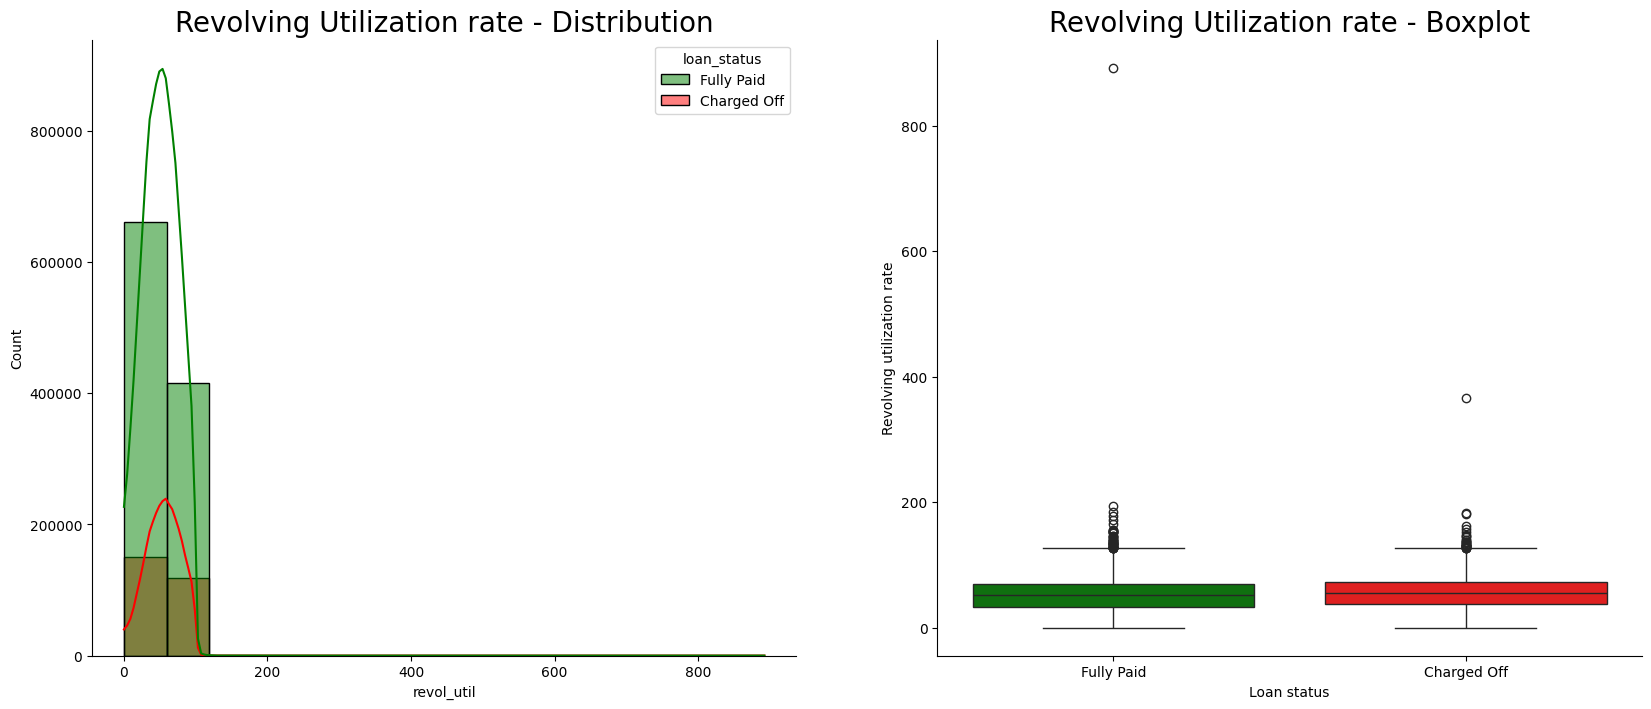

In [53]:
fig, ax =plt.subplots(1,2,figsize=(20,8))

sns.despine()

ax[0].tick_params(axis='x', labelrotation=0)
ax[0].set(xlabel='revol_util', ylabel='')
ax[0].set_title('Revolving Utilization rate - Distribution', size=20)
ax[1].tick_params(axis='x', labelrotation=0)
ax[1].set_title('Revolving Utilization rate - Boxplot', size=20)

sns.histplot(data=df,x="revol_util",hue="loan_status",bins=15,
             kde=True,ax=ax[0], palette={'Fully Paid': 'green', 'Charged Off': 'red'})
sns.boxplot(data=df,x="loan_status",y="revol_util",ax=ax[1],palette={'Fully Paid': 'green', 'Charged Off': 'red'}).set(xlabel='Loan status', ylabel='Revolving utilization rate')

The majority of counts for both loan statuses are concentrated near the lower end of the Revolving Utilization Rate axis, which suggests that most borrowers use a lower portion of their available credit.
The peak of the distribution for both categories is very close to zero, indicating that the mode of the distribution is low.
The distribution for "Fully Paid" loans (in green) appears to be higher and more spread out than for "Charged Off" loans (in red), which implies a greater variety of utilization rates among borrowers who fully paid their loans.
There are several outliers for both loan statuses, as indicated by the points beyond the 'whiskers' of the boxplots. These outliers represent borrowers with unusually high or low Revolving Utilization Rates compared to the rest of the population.
In summary, loans that are fully paid tend to have lower revolving utilization rates, while charged-off loans have a higher and more variable range of utilization rates. This could indicate that borrowers with higher credit utilization are at a greater risk of not fulfilling their loan obligations.

`pub_rec_bankruptcies`

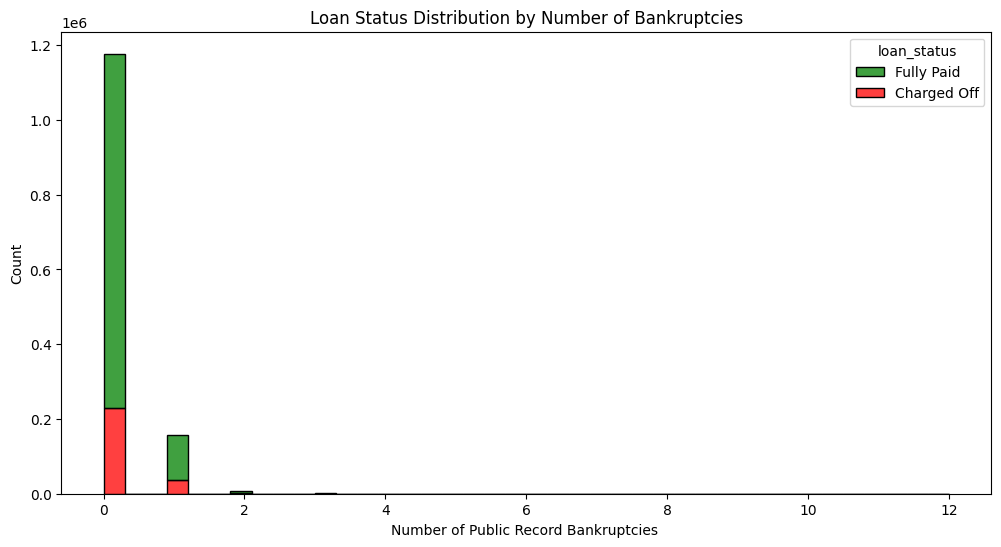

In [54]:
plt.figure(figsize=(12, 6))

sns.histplot(df, x="pub_rec_bankruptcies", bins=40, hue="loan_status", multiple="stack", palette={'Fully Paid': 'green', 'Charged Off': 'red'})
plt.title("Loan Status Distribution by Number of Bankruptcies")
plt.xlabel("Number of Public Record Bankruptcies ")
plt.ylabel("Count")

plt.show()

The data indicates that borrowers with no public record of bankruptcy are more likely to fully pay off their loans, and the likelihood of both fully paying a loan and having a loan charged off decreases as the number of bankruptcies increases. This suggests that bankruptcy is a strong indicator of loan repayment risk.
For borrowers with one bankruptcy, there are still more fully paid loans than charged off, but the number of loans is significantly lower compared to borrowers with no bankruptcies.
As the number of bankruptcies increases to two or more, the number of loans drops drastically and becomes minimal.

In [55]:
df_co = df[df['loan_status'] == 'Charged Off'].groupby('pub_rec_bankruptcies').count()[['loan_status']]

df_total = df.groupby('pub_rec_bankruptcies').count()[['loan_status']]

percent_co = df_co / df_total * 100

percent_co.rename(columns={'loan_status': 'Percentage Charged Off Loans'}).reset_index()

,pub_rec_bankruptcies,Percentage Charged Off Loans
0,0.0,19.581411
1,1.0,22.526887
2,2.0,24.790835
3,3.0,22.615287
4,4.0,27.777778
5,5.0,23.404255
6,6.0,34.782609
7,7.0,26.666667
8,8.0,44.444444
9,9.0,33.333333


`mort_acc`

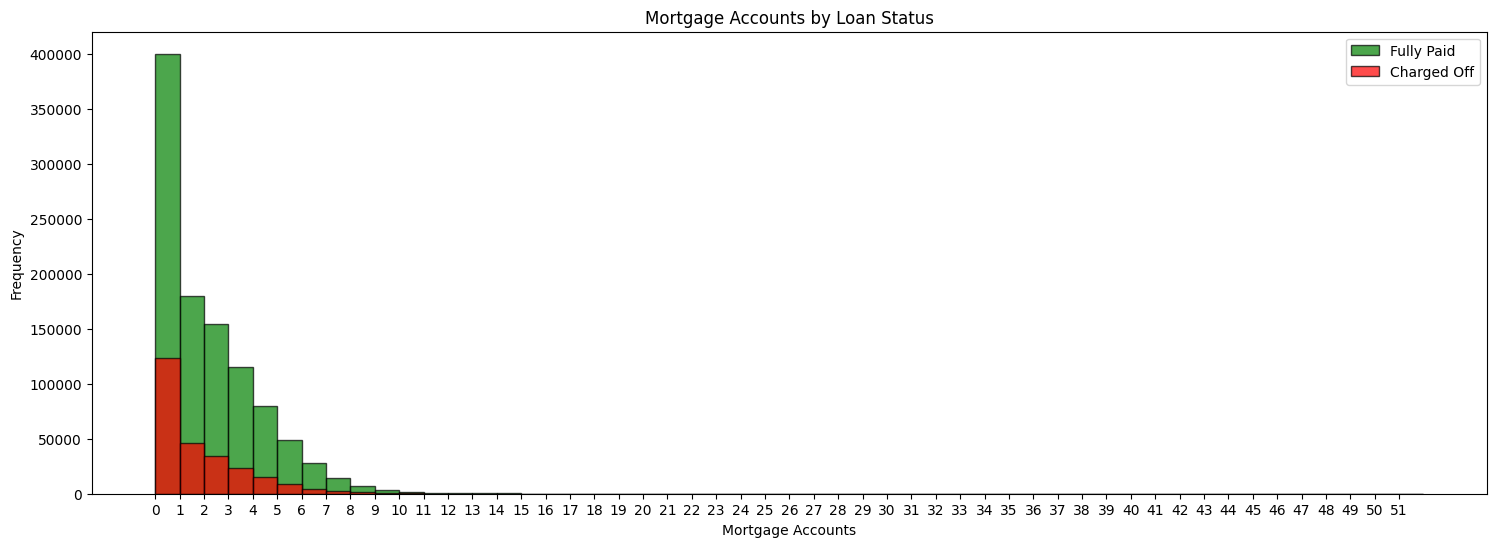

In [56]:
plt.figure(figsize=(18, 6))

status_colors = {'Fully Paid': 'green', 'Charged Off': 'red'}

for status, color in status_colors.items():
    subset = df[df['loan_status'] == status]
    plt.hist(subset['mort_acc'], bins=range(int(df['mort_acc'].min()), int(df['mort_acc'].max()) + 2), 
             alpha=0.7, label=status, color=color, edgecolor='black')

plt.title('Mortgage Accounts by Loan Status')
plt.xlabel('Mortgage Accounts')
plt.ylabel('Frequency')
plt.xticks(range(int(df['mort_acc'].min()), int(df['mort_acc'].max()) + 1))
plt.legend()
plt.show()


Most of the loans are paid off in full no matter how many mortgage accounts people have. There are generally fewer loans as people have more mortgage accounts, but there is a small increase again when people have four mortgage accounts. 

`emp_title`

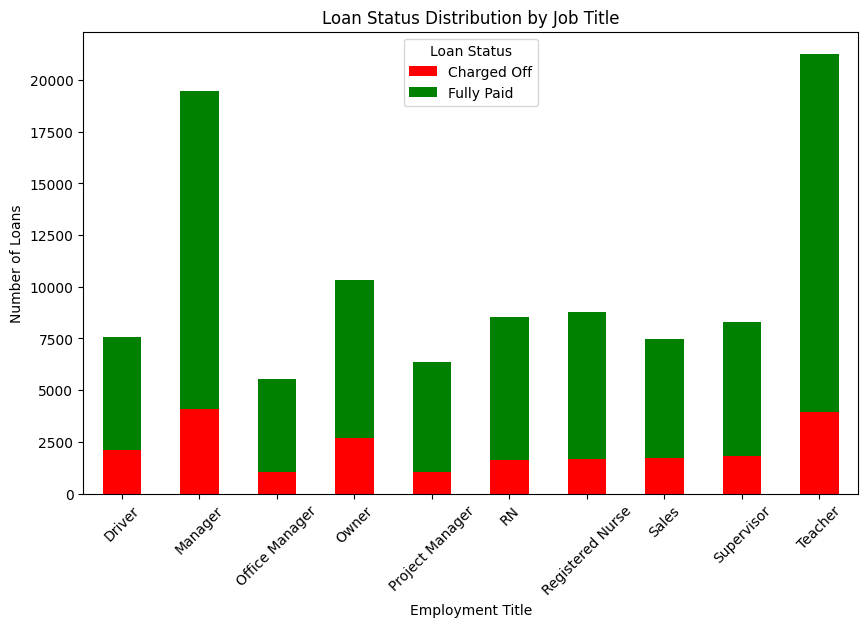

In [57]:
top_job_titles = df['emp_title'].value_counts().nlargest(10).index
filtered_df = df[df['emp_title'].isin(top_job_titles)]

pivot_table = pd.crosstab(index=filtered_df['emp_title'], columns=filtered_df['loan_status'])

pivot_table.plot(kind='bar', stacked=True, figsize=(10, 6),color = {'Fully Paid': 'green', 'Charged Off': 'red'} )
plt.title('Loan Status Distribution by Job Title')
plt.xlabel('Employment Title')
plt.ylabel('Number of Loans')
plt.xticks(rotation=45)
plt.legend(title='Loan Status')
plt.show()

The data suggests that certain professions, like "Teacher" and "Manager," may have a higher number of loans but also a higher rate of fully paying them off. In contrast, other professions like "Driver" and "Registered Nurse" have fewer loans in this dataset. This could potentially inform financial institutions about the loan repayment patterns associated with different employment titles.